In [ ]:
!pip install transformers datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 6.8 MB/s 
     |████████████████████████████████| 365 kB 56.3 MB/s 
     |████████████████████████████████| 120 kB 53.0 MB/s 
     |████████████████████████████████| 6.6 MB 53.1 MB/s 
     |████████████████████████████████| 115 kB 47.6 MB/s 
     |████████████████████████████████| 212 kB 58.9 MB/s 
     |████████████████████████████████| 127 kB 37.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from transformers import TFElectraModel
from transformers import ElectraTokenizer

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
strategy = tf.distribute.get_strategy()

In [ ]:
import datasets
from datasets import load_dataset, load_metric, ClassLabel, Sequence

datasets = load_dataset("klue", "nli")

  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
datasets

DatasetDict({
    train: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 24998
    })
    validation: Dataset({
        features: ['guid', 'source', 'premise', 'hypothesis', 'label'],
        num_rows: 3000
    })
})

In [ ]:
train_premise = datasets["train"]["premise"]
train_hypothesis = datasets["train"]["hypothesis"]
train_label = datasets["train"]["label"]

test_premise = datasets["validation"]["premise"]
test_hypothesis = datasets["validation"]["hypothesis"]
test_label = datasets["validation"]["label"]

In [ ]:
train = pd.DataFrame({"premise":train_premise,
                         "hypothesis":train_hypothesis,
                         "label":train_label})
test = pd.DataFrame({"premise":test_premise,
                         "hypothesis":test_hypothesis,
                         "label":test_label})

In [ ]:
train.head(10)

,premise,hypothesis,label
0,힛걸 진심 최고다 그 어떤 히어로보다 멋지다,힛걸 진심 최고로 멋지다.,0
1,100분간 잘껄 그래도 소닉붐땜에 2점준다,100분간 잤다.,2
2,100분간 잘껄 그래도 소닉붐땜에 2점준다,소닉붐이 정말 멋있었다.,1
3,100분간 잘껄 그래도 소닉붐땜에 2점준다,100분간 자는게 더 나았을 것 같다.,1
4,101빌딩 근처에 나름 즐길거리가 많습니다.,101빌딩 근처에서 즐길거리 찾기는 어렵습니다.,2
5,101빌딩 근처에 나름 즐길거리가 많습니다.,101빌딩 주변에 젊은이들이 즐길거리가 많습니다.,1
6,101빌딩 근처에 나름 즐길거리가 많습니다.,101빌딩 부근에서는 여러가지를 즐길수 있습니다.,0
7,10년 만에 찾는 피터를 웬디는 따뜻하게 맞이하고 피터는 성공리에 연설을 마치는데 ...,웬디는 피터를 차갑게 맞이했다.,2
8,10년 만에 찾는 피터를 웬디는 따뜻하게 맞이하고 피터는 성공리에 연설을 마치는데 ...,잭과 매기는 피터 배닝의 동생들이다.,1
9,10년 만에 찾는 피터를 웬디는 따뜻하게 맞이하고 피터는 성공리에 연설을 마치는데 ...,"피터 배닝, 잭, 매기는 남매사이다.",0


In [ ]:
train.shape, test.shape

((24998, 3), (3000, 3))

In [ ]:
train.isnull().sum()

premise       0
hypothesis    0
label         0
dtype: int64

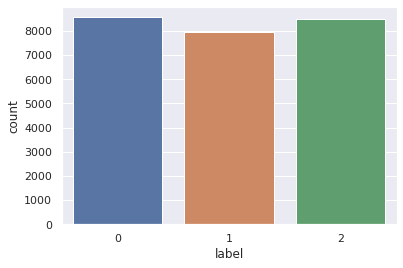

In [ ]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained("monologg/koelectra-base-v3-discriminator")

In [ ]:
train_data = train[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

In [ ]:
train_encoded_electra = tokenizer.batch_encode_plus(train_data)
test_encoded_electra = tokenizer.batch_encode_plus(test_data)  # input_ids, token_type_ids, attention_mask

In [ ]:
cal_length = train_encoded_electra['input_ids'] + test_encoded_electra['input_ids']

num_tokens = [len(tokens) for tokens in cal_length]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

토큰 길이 평균: 40.54027301315037
토큰 길이 최대: 94
토큰 길이 표준편차: 13.56393365965071


In [ ]:
test_num_tokens_electra = [len(tokens) for tokens in test_encoded_electra['input_ids']]
print(f"토큰 길이 최대: {np.max(test_num_tokens_roberta)}")

토큰 길이 최대: 87


In [ ]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
        
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
below_threshold_len(90,cal_length)

전체 샘플 중 길이가 90 이하인 샘플의 비율: 0.9998570611778159


In [ ]:
select_length = 90

In [ ]:
# 90 이상인 샘플 삭제
temp = []
for i in range(len(train_encoded_electra['input_ids'])):
    if len(train_encoded_electra['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del train_data[i]
    train.drop(train.index[i], inplace=True)
    
temp = []
for i in range(len(test_encoded_electra['input_ids'])):
    if len(test_encoded_electra['input_ids'][i]) > select_length:
        temp.append(i)

temp.reverse()

for i in temp:
    del test_data[i]
    test.drop(test.index[i], inplace=True)

In [ ]:
train_data = train[['premise', 'hypothesis']].values.tolist()
test_data = test[['premise', 'hypothesis']].values.tolist()

In [ ]:
train_encoded_electra = tokenizer.batch_encode_plus(train_data)
test_encoded_electra = tokenizer.batch_encode_plus(test_data)

In [ ]:
cal_length = train_encoded_electra['input_ids'] + test_encoded_electra['input_ids']

In [ ]:
below_threshold_len(select_length, cal_length)

전체 샘플 중 길이가 90 이하인 샘플의 비율: 1.0


In [ ]:
len(train_data), len(test_data)

(24980, 3000)

# 모델링

In [ ]:
train_encoded_electra = tokenizer.batch_encode_plus(train_data, padding='max_length', max_length=90)
test_encoded_electra = tokenizer.batch_encode_plus(test_data, padding='max_length', max_length=90)

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(train_encoded_electra['input_ids'], train.label.values, test_size=0.3, random_state=777)
x_test = test_encoded_electra['input_ids']

In [ ]:
train_dataset = (tf.data.Dataset.from_tensor_slices((x_train, y_train)).repeat().shuffle(2048).batch(20 * strategy.num_replicas_in_sync).prefetch(tf.data.experimental.AUTOTUNE))
valid_dataset = (tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(20 * strategy.num_replicas_in_sync).cache().prefetch(tf.data.experimental.AUTOTUNE))
test_dataset = (tf.data.Dataset.from_tensor_slices(x_test).batch(20 * strategy.num_replicas_in_sync))

In [ ]:
def model_KoELECTRA():
    with strategy.scope():
        encoder = TFElectraModel.from_pretrained("monologg/koelectra-base-v3-discriminator", from_pt=True)

        input_layer = Input(shape=(90,), dtype=tf.int32, name="input_layer")
        sequence_output = encoder(input_layer)[0]

        cls_token = sequence_output[:, 0, :]

        output_layer = Dense(3, activation='softmax')(cls_token)

        model = Model(inputs=input_layer, outputs=output_layer)
        model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = model_KoELECTRA()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFElectraModel: ['discriminator_predictions.dense.weight', 'electra.embeddings.position_ids', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing TFElectraModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFElectraModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further train

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 90)]              0         
                                                                 
 tf_electra_model (TFElectra  TFBaseModelOutputWithPas  112330752
 Model)                      tAndCrossAttentions(last            
                             _hidden_state=(None, 90,            
                              768),                              
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                             

In [ ]:
history = model.fit(train_dataset, steps_per_epoch=len(train) // 20 * strategy.num_replicas_in_sync,
                  validation_data=valid_dataset,epochs= 3)

Epoch 1/3
1249/1249 [==============================] - 362s 274ms/step - loss: 0.5125 - accuracy: 0.7901 - val_loss: 0.4030 - val_accuracy: 0.8642
Epoch 2/3
1249/1249 [==============================] - 338s 270ms/step - loss: 0.2361 - accuracy: 0.9173 - val_loss: 0.4157 - val_accuracy: 0.8796
Epoch 3/3
1249/1249 [==============================] - 338s 271ms/step - loss: 0.1162 - accuracy: 0.9603 - val_loss: 0.5016 - val_accuracy: 0.8719


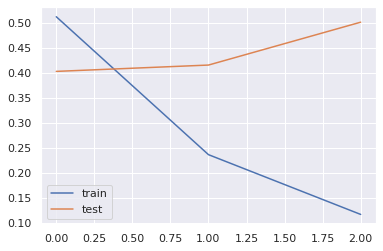

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
pred = model.predict(test_dataset, verbose=1)
pred_arg = pred.argmax(axis=1)

150/150 [==============================] - 17s 92ms/step


In [ ]:
from sklearn.metrics import accuracy_score

accuracy_score(test['label'], pred_arg)

0.849